In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
import cv2
import re
import seaborn as sns
import matplotlib.pyplot as plt

import random

%matplotlib inline 

In [3]:
def findCorners(img, alpha=0.05, thresh=10):
    """
    Finds and returns list of harris corners
    img: The original image (input as grayscale)
    alpha: Harris corner constant. Usually 0.04 - 0.06
    thresh: The threshold above which a corner is counted
    returns corner list, R value list, x and y gradient images:
    """
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]

    cornerList = []
    R_list = []
    offset = 1

    #Loop through image and find our corners
    print ("Finding Corners...")
    for row in range(offset, height-offset):
        for col in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[row-offset:row+offset+1, col-offset:col+offset+1]
            windowIxy = Ixy[row-offset:row+offset+1, col-offset:col+offset+1]
            windowIyy = Iyy[row-offset:row+offset+1, col-offset:col+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            Det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            R = Det - alpha*(trace**2)

            #If corner response is over threshold, color the point and add to corner list
            if R > thresh:
                cornerList.append([row, col])
                R_list.append(R)
    return np.array(cornerList), np.array(R_list), dy, dx

In [4]:
img = cv2.imread("exp/Fusion/files/hw2/img1.jpg"); img.shape

(320, 240, 3)

In [5]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

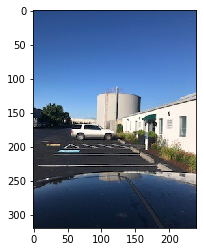

In [6]:
fig, ax = plt.subplots()
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax.imshow(img_rgb, interpolation='nearest')
plt.show()

In [7]:
cornerList, R_list, dy, dx =findCorners(img_gray, alpha=0.05, thresh=100000)

Finding Corners...


In [8]:
len(cornerList)

9026

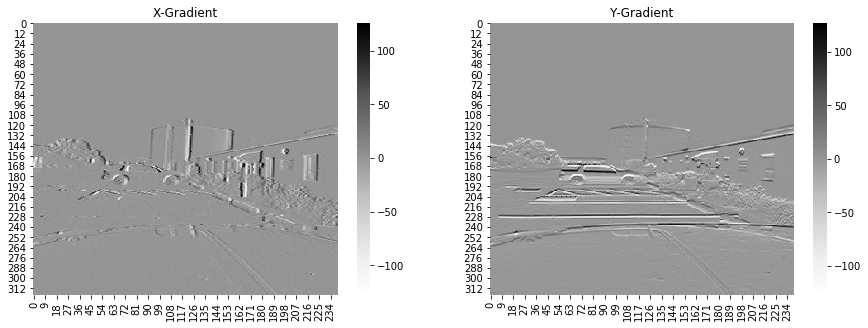

In [9]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'hspace': 0.9, 'wspace': 0.2}, figsize=(15,5))
sns.heatmap(dx, ax=ax[0], cmap='Greys')
ax[0].set_title('X-Gradient')
sns.heatmap(dy, ax=ax[1], cmap='Greys')
ax[1].set_title('Y-Gradient')
plt.show()

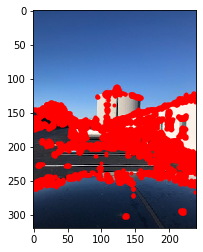

In [10]:
fig, ax = plt.subplots()
ax.imshow(img_rgb, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(cornerList[:, 1], cornerList[:, 0], 'or', markersize=3)
plt.show()

In [11]:
img2 = cv2.imread("exp/Fusion/files/hw2/img2.jpg");
img3 = cv2.imread("exp/Fusion/files/hw2/img3.jpg");
img4 = cv2.imread("exp/Fusion/files/hw2/img4.jpg");

In [12]:
threshhold=100000
alpha=0.05

kypnts1, _, _, _ = findCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), alpha=alpha, thresh=threshhold)
kypnts2, _, _, _ = findCorners(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), alpha=alpha, thresh=threshhold)
kypnts3, _, _, _ = findCorners(cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY), alpha=alpha, thresh=threshhold)
kypnts4, _, _, _ = findCorners(cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY), alpha=alpha, thresh=threshhold)

Finding Corners...
Finding Corners...
Finding Corners...
Finding Corners...


In [13]:
#
# Runs sift algorithm to find features
#
def findFeatures(img):
    print("Finding Features...")
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(
        cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), None)

   # img = cv2.drawKeypoints(img, keypoints)
   # cv2.imwrite('sift_keypoints.png', img)

    return keypoints, descriptors

#
# Matches features given a list of keypoints, descriptors, and images
#
def matchFeatures(kp1, kp2, desc1, desc2, img1, img2):
    print("Matching Features...")
    matcher = cv2.BFMatcher(cv2.NORM_L2, True)
    matches = matcher.match(desc1, desc2)
    #matchImg = drawMatches(img1,kp1,img2,kp2,matches)
    #cv2.imwrite('Matches.png', matchImg)
    return matches

In [14]:
#
#Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print ("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

In [15]:
#
# Computers a homography from 4-correspondences
#
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [16]:
#
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [17]:
# find features and keypoints
kp1, desc1 = findFeatures(img)
kp2, desc2 = findFeatures(img2)
print ("Found keypoints in first image: " + str(len(kp1)))
print ("Found keypoints in second image: " + str(len(kp2)))

# find correspondances given a list of keypoints
keypoints = [kp1,kp2]
matches = matchFeatures(kp1, kp2, desc1, desc2, img, img2)
correspondenceList = []
for match in matches:
    (x1, y1) = keypoints[0][match.queryIdx].pt
    (x2, y2) = keypoints[1][match.trainIdx].pt
    correspondenceList.append([x1, y1, x2, y2])

corrs = np.matrix(correspondenceList)

# run ransac algorithm
#       find 4 random points to calculate a homography
#       compute homography function on those points
#       compute inliers
estimation_thresh = 0.60
finalH, inliers = ransac(corrs, estimation_thresh)
print ("Final homography: ", finalH)
print ("Final inliers count: ", len(inliers))

Finding Features...
Finding Features...
Found keypoints in first image: 203
Found keypoints in second image: 213
Matching Features...
Corr size:  140  NumInliers:  8 Max inliers:  8
Corr size:  140  NumInliers:  89 Max inliers:  89
Final homography:  [[ 1.36395997e+00  1.21063301e-02 -7.79824606e+01]
 [ 2.63017510e-01  1.26827572e+00 -4.09411980e+01]
 [ 1.56529648e-03  1.43465411e-04  1.00000000e+00]]
Final inliers count:  89


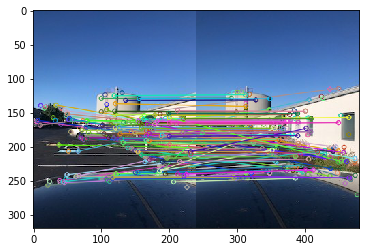

In [18]:
img_match=cv2.drawMatches(img,kp1,img2,kp2,matches, None)
    
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB), interpolation='nearest')
plt.show()

In [19]:
def cvshow(name,img):
    
    fig, ax = plt.subplots()
   
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='nearest')
    ax.set_title(name)
    plt.show()

def sift_kp(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    kp_image = cv2.drawKeypoints(gray_image, kp, None)
    return kp_image, kp, des


def get_good_match(des1, des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)  # des1 is the template image, des2 is the matching image
    matches = sorted(matches, key=lambda x: x[0].distance / x[1].distance)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    return good

def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # Initialize the visualization picture, connect the A and B pictures left and right together
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # Joint traversal, draw matching pairs
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # When the point pair is matched successfully, draw it on the visualization
        if s == 1:
            # Draw matching pairs
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

    # Return visualization results
    return vis


# Panorama stitching
def siftimg_rightlignment(img_right, img_left):
    _, kp1, des1 = sift_kp(img_right)
    _, kp2, des2 = sift_kp(img_left)
    goodMatch = get_good_match(des1, des2)
    # When the matching pairs of the filter items are greater than 4 pairs: calculate the perspective transformation matrix
    if len(goodMatch) > 4:
        # Get the point coordinates of the matching pair
        ptsA = np.float32([kp1[m.queryIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
        ptsB = np.float32([kp2[m.trainIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
        ransacReprojThreshold = 4
        H, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold)
        # The function of this function is to first use RANSAC to select the best four sets of pairing points, and then calculate the H matrix. H is a 3*3 matrix

        # Change the angle of view to the right of the picture, result is the transformed picture
        result = cv2.warpPerspective(img_right, H, (img_right.shape[1] + img_left.shape[1], img_right.shape[0]))
        #cvshow('result_medium', result)
        # Pass the picture left to the left end of the result picture
        result[0:img_left.shape[0], 0:img_left.shape[1]] = img_left
        return result

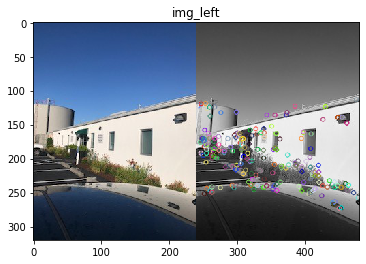

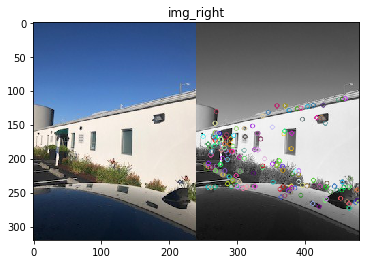

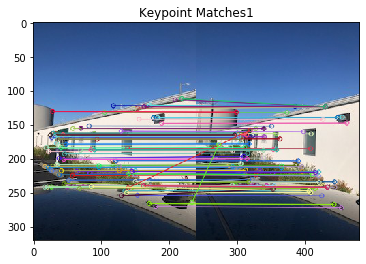

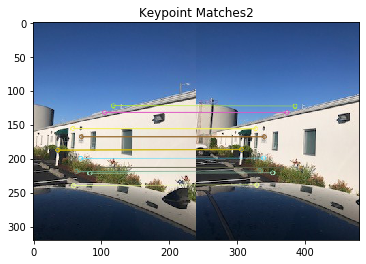

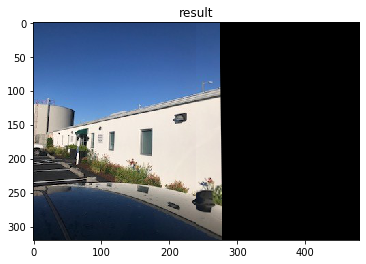

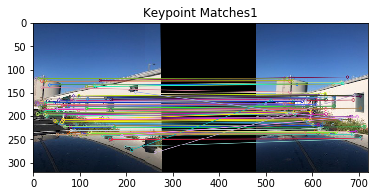

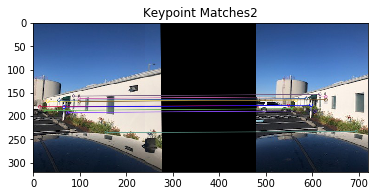

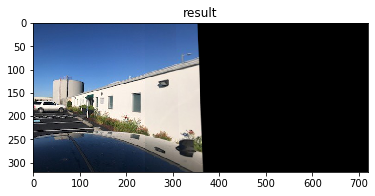

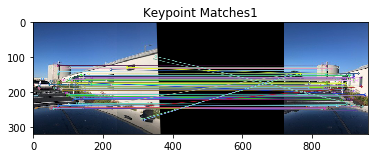

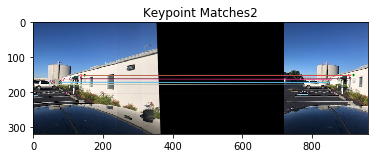

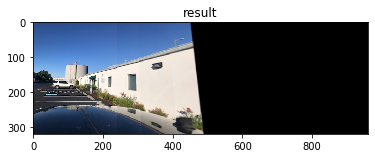

In [22]:
## Stitches right to left
img_right=img4.copy()

for i, img_ in enumerate([img3, img2, img]):
    img_left=img_.copy()
    kpimg_right, kp1, des1 = sift_kp(img_right)
    kpimg_left, kp2, des2 = sift_kp(img_left)

    # Display the original image and the image after key point detection at the same time
    if i ==0: 
        cvshow('img_left',np.hstack((img_left,kpimg_left)))
        cvshow('img_right',np.hstack((img_right,kpimg_right)))
    goodMatch = get_good_match(des1, des2)

    all_goodmatch_img= cv2.drawMatches(img_right, kp1, img_left, kp2, goodMatch, None, flags=2)

    # goodmatch_img Set the first goodMatch[:10]
    goodmatch_img = cv2.drawMatches(img_right, kp1, img_left, kp2, goodMatch[:10], None, flags=2)


    cvshow('Keypoint Matches1', all_goodmatch_img)
    cvshow('Keypoint Matches2', goodmatch_img)

    result=siftimg_rightlignment(img_right,img_left)

    cvshow('result',result)

    img_right=result.copy()

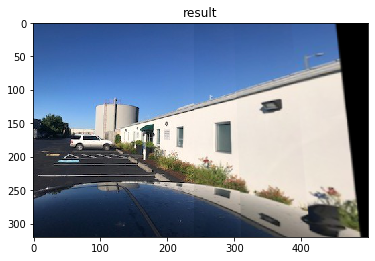

In [24]:
cvshow('result',result[:,:500])

# Convert video to corner counted

In [ ]:
def draw_outline(o, lw, foreground='black'):
    import matplotlib.patheffects as patheffects
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground=foreground), patheffects.Normal()])

In [ ]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [ ]:

# Read until video is completed
cap = cv2.VideoCapture("exp/Fusion/files/hw2/vid1.mov")

alpha=0.05
thresh=100000
count=0
while(cap.isOpened()):

    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:

        # Display the resulting frame
        
        #cv2.imshow('Frame',frame)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cornerList, R_list, dy, dx =findCorners(gray_frame, alpha=alpha, thresh=thresh)
        
        
        fig, ax = plt.subplots(frameon=False)
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), interpolation='nearest')
        ax.plot(cornerList[:, 1], cornerList[:, 0], 'or', markersize=1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
        draw_outline(ax.text(25,50,f'Alpha: {alpha}, Threshold: {thresh}\nHarris Corner Count:{len(cornerList)}', ha='left',fontsize=14,color='white'),lw=1, foreground='black')
        fig.savefig(f'exp/Fusion/files/hw2/frame{count}.png', bbox_inches='tight', pad_inches=0)

        
        
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break



    # Break the loop

    else:    break
    #if count==3: break    
    count+=1
cap.release()
cv2.destroyAllWindows()

In [ ]:
path=f'exp/Fusion/files/hw2/'
files=[o for o in os.listdir(path) if o.find('frame')==0]

In [ ]:
files=natural_sort(files)

In [ ]:
frame_array = []
for i,fl in enumerate(files):
    filename=f'{path}{fl}'
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    #print(filename)
    #inserting the frames into an image array
    frame_array.append(img)

In [ ]:
fps=10
out = cv2.VideoWriter(f'{path}HarrisClip.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [21]:

end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Sunday June 20, 2021 at 08:27
